In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

import importlib
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import librosa

import dataset

In [2]:
importlib.reload(dataset)

<module 'dataset' from '/home/sazim/teams/ece251c-team-11/code/dataset.py'>

In [3]:
# define device type - cuda:0 or cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
kwargs = {'num_workers': 4, 'pin_memory': False} if device.type == "cuda" else {}

# Additional Info when using cuda
if device.type == 'cuda':
    print("Number of GPU devices:", torch.cuda.device_count())
    print("GPU device name:", torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3, 3), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3, 3), 'GB')

Number of GPU devices: 1
GPU device name: GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [4]:
NUM_EPOCHS = 1
TRAIN_BATCH_SIZE = 1
TEST_BATCH_SIZE = 1

In [5]:
class CausalConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_layer = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=(3, 3),
            
            stride=(2, 1),
            padding=(0, 1)
        )
        
        self.norm = nn.BatchNorm2d(num_features=out_channels)
        self.activation = nn.ReLU()

    def forward(self, x):
        """
        2D Causal convolution.
        Args:
            x: [batch_size, num_channels, F, T]
        Returns:
            [B, C, F, T]
        """
        x = self.conv_layer(x)
#         x = x[:, :, :, :-1]  # chomp size
        x = self.norm(x)
        x = self.activation(x)
        
        return x

In [6]:
class CausalTransConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, is_last=False, output_padding=(0, 0)):
        super().__init__()
        
        self.conv = nn.ConvTranspose2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=(3, 3),
            stride=(2, 1),
            output_padding=output_padding
        
        )
        
        self.norm = nn.BatchNorm2d(num_features=out_channels)
        if is_last:
            self.activation = nn.ReLU()
        else:
            self.activation = nn.ELU()

    def forward(self, x):
        """
        2D Causal convolution.
        Args:
            x: [B, C, F, T]
        Returns:
            [B, C, F, T]
        """
        x = self.conv(x)
        x = x[:, :, :, :-2]  # chomp size
        x = self.norm(x)
        x = self.activation(x)
        
        return x

In [7]:
class ConvRecNet(nn.Module):
    """
    Input: [batch size, channels=1, T, n_fft]
    Output:[batch size, channels=1, T, n_fft]
    """
    
    def __init__(self):
        super(ConvRecNet, self).__init__()
        
        # Encoder
        self.conv_block_1 = CausalConvBlock(1, 16)
        self.conv_block_2 = CausalConvBlock(16, 32)
        self.conv_block_3 = CausalConvBlock(32, 64)
        self.conv_block_4 = CausalConvBlock(64, 128)
        self.conv_block_5 = CausalConvBlock(128, 256)
        
        # LSTM
        self.lstm_layer = nn.LSTM(input_size=256*31, hidden_size=256*31, num_layers=2, batch_first=True)
        
        self.tran_conv_block_1 = CausalTransConvBlock(256 + 256, 128)
        self.tran_conv_block_2 = CausalTransConvBlock(128 + 128, 64)
        self.tran_conv_block_3 = CausalTransConvBlock(64 + 64, 32)
        self.tran_conv_block_4 = CausalTransConvBlock(32 + 32, 16, output_padding=(1, 0))
        self.tran_conv_block_5 = CausalTransConvBlock(16 + 16, 1, is_last=True)

        
    def forward(self, x):
        self.lstm_layer.flatten_parameters()
#         print(x.shape)

        e1 = self.conv_block_1(x)
        e2 = self.conv_block_2(e1)
        e3 = self.conv_block_3(e2)
        e4 = self.conv_block_4(e3)
        e5 = self.conv_block_5(e4)  # [2, 256, 4, 200]
#         e5 = e4

        batch_size, n_channels, n_f_bins, n_frame_size = e5.shape

        # [2, 256, 4, 200] = [2, 1024, 200] => [2, 200, 1024]
        lstm_in = e5.reshape(batch_size, n_channels * n_f_bins, n_frame_size).permute(0, 2, 1)
        lstm_out, _ = self.lstm_layer(lstm_in)  # [2, 200, 1024]
        lstm_out = lstm_out.permute(0, 2, 1).reshape(batch_size, n_channels, n_f_bins, n_frame_size)  # [2, 256, 4, 200]

#         d1 = lstm_out
        d1 = self.tran_conv_block_1(torch.cat((lstm_out, e5), 1))
        d2 = self.tran_conv_block_2(torch.cat((d1, e4), 1))
        d3 = self.tran_conv_block_3(torch.cat((d2, e3), 1))
        d4 = self.tran_conv_block_4(torch.cat((d3, e2), 1))
        d5 = self.tran_conv_block_5(torch.cat((d4, e1), 1))
        
        return d5

In [8]:
model = ConvRecNet()
model = model.to(device)

In [9]:
a = torch.rand((1, 1, 1025, 127), device=device)
print(a.shape, model(a).shape)

RuntimeError: CUDA out of memory. Tried to allocate 3.77 GiB (GPU 0; 10.76 GiB total capacity; 3.83 GiB already allocated; 1.90 GiB free; 7.53 GiB reserved in total by PyTorch)

In [10]:
train_dataset = dataset.SpeechDataset('train')
train_dataloader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, collate_fn=dataset.custom_collate_fn)
print("Train dataset size:", len(train_dataloader))
# itr = next(iter(train_dataloader))

Train dataset size: 49680


In [11]:
test_dataset = dataset.SpeechDataset('test')
test_dataloader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, collate_fn=dataset.custom_collate_fn)
print("Test dataset size:", len(test_dataloader))

Test dataset size: 4259


In [12]:
# understand dataloader
# for i in range(10):
#     clean_spec, noisy_spec = next(iter(test_dataloader))
# #     print(len(clean_spec), len(noisy_spec))  # (4, 4)

#     print(clean_spec[0].shape, noisy_spec[0].shape)
#     print("\n")

In [13]:
LR = 1e-3
LR_STEP_SIZE = 50   # How often to decrease learning by gamma.
GAMMA = 0.1         # LR is multiplied by gamma on schedule

# criterion = nn.CrossEntropyLoss().to(device)
loss_criterion = nn.MSELoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=LR_STEP_SIZE, gamma=GAMMA)

In [18]:
# start_time = time.time()

# num_batches = len(train_dataloader)
num_batches = 1000
model_save_path = "../trained_model_ckpts/checkpoint.pth.tar"

losses = []

# switch to train mode
model.train()

for epoch in tqdm(range(NUM_EPOCHS)):
    for itr in tqdm(range(num_batches)):
#         print("{}/{}".format(itr, num_batches))
        clean_spec, noisy_spec = next(iter(train_dataloader))
        
        # compute the magnitude response of clean and noisy spectrograms
        clean_spec_mag = torch.unsqueeze(torch.abs(clean_spec[0]), 0)
        clean_spec_mag = torch.unsqueeze(clean_spec_mag, 0).to(device, dtype=torch.float)
        
        noisy_spec_mag = torch.unsqueeze(torch.abs(noisy_spec[0]), 0)
        noisy_spec_mag = torch.unsqueeze(noisy_spec_mag, 0).to(device, dtype=torch.float)
        
#         print(clean_spec_mag.shape, noisy_spec_mag.shape)
        
        model_out = model(noisy_spec_mag).type(torch.float)
#         print(clean_spec_mag.shape, noisy_spec_mag.shape, model_out.shape)
        
        loss = loss_criterion(clean_spec_mag, model_out)
        
        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    torch.save({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }, model_save_path)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

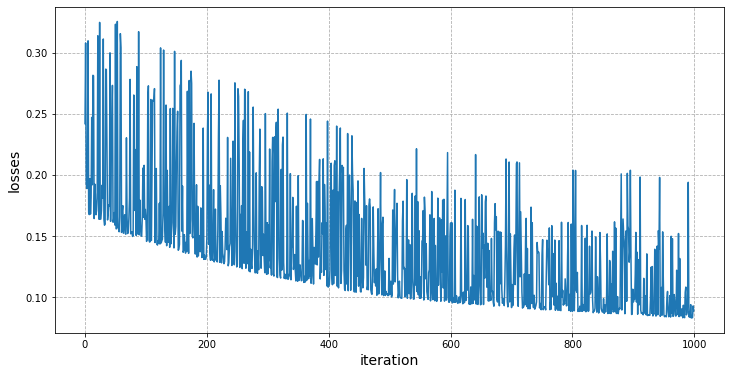

In [19]:
fig = plt.figure(figsize=(12,6))
plt.plot(losses)
plt.xlabel("iteration", fontsize=14)
plt.ylabel("losses", fontsize=14)
plt.grid(linestyle='--')
plt.show()

In [15]:
model_save_path = "../trained_model_ckpts/checkpoint.pth.tar"
model_checkpoint = torch.load(f=model_save_path)
# model = models.get_architecture(model_checkpoint["arch"], args.dataset_name, device)
model.load_state_dict(model_checkpoint['state_dict'])

<All keys matched successfully>

In [14]:
# num_batches = len(test_dataloader)
num_batches = 5

for itr in tqdm(range(num_batches)):
    clean_spec, noisy_spec = next(iter(test_dataloader))
    
    clean_spec = clean_spec[0].to(device)
    noisy_spec = noisy_spec[0].to(device)
#     print(clean_spec.shape, noisy_spec.shape)

    # compute the magnitude response of clean and noisy spectrograms
    clean_spec_mag = torch.abs(clean_spec).type(torch.float)
    noisy_spec_mag = torch.abs(noisy_spec).type(torch.float)
    noisy_spec_phase = noisy_spec / noisy_spec_mag

    model_out = model(noisy_spec_mag.unsqueeze(0).unsqueeze(0))

    # combine the model_out(magnitude) and phase to recover partially clean spectrogram
    clean_spec_pred = torch.multiply(model_out.squeeze(0).squeeze(0), noisy_spec_phase)
    print(clean_spec_pred.shape, clean_spec_pred.dtype)
    
    clean_signal_gt = librosa.istft(clean_spec.cpu().detach().numpy(), win_length=256, hop_length=512)
    clean_signal_pred = librosa.istft(clean_spec_pred.cpu().detach().numpy(), win_length=256, hop_length=512)
    print(clean_signal_gt.shape, clean_signal_pred.shape)

#     loss = loss_criterion(clean_spec_mag, model_out)
#     losses.append(loss.item())

  0%|          | 0/5 [00:00<?, ?it/s]

complex128 complex128


RuntimeError: CUDA out of memory. Tried to allocate 3.76 GiB (GPU 0; 10.76 GiB total capacity; 7.52 GiB already allocated; 1.90 GiB free; 7.54 GiB reserved in total by PyTorch)

In [50]:
a = torch.rand((2,2), dtype=torch.complex64)
print(a)
b = np.abs(a)
c = torch.abs(a)
print(b.dtype, c.dtype)

tensor([[0.9287+0.4740j, 0.9390+0.3126j],
        [0.3815+0.2898j, 0.9256+0.5530j]])
torch.float32 torch.float32
